# Finetune a stable diffusion model for text to image generation

***
Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)에 오신 것을 환영합니다! SageMaker Studio에서 원클릭으로 또는 [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart)를 통해 JumpStart를 사용하여 다양한 머신러닝 작업을 해결할 수 있습니다. 이 데모 노트북에서는 JumpStart API를 사용하여  state-of-the-art Stable Diffusion 모델을 사용하여 텍스트에서 이미지를 생성하는 방법을 보여줍니다. 또한 데이터 세트에 맞게 모델을 fine-tune하는 방법도 보여드립니다.

Stable Diffusion은 텍스트 프롬프트만으로 사실적인 이미지를 생성할 수 있는 텍스트-이미지 모델입니다. diffusion 모델은 실제 이미지에 추가된 노이즈를 제거하는 방법을 학습하여 훈련합니다. 이 노이즈 제거 과정을 통해 사실적인 이미지가 생성됩니다. 이러한 모델은 텍스트에 대한 생성 프로세스를 조절하여 텍스트만으로 이미지를 생성할 수도 있습니다. 예를 들어, Stable Diffusion은 모델이 순수한 노이즈 이미지에서 shape을 인식하는 방법을 학습하고 입력 텍스트의 단어와 도형이 일치하는 경우 점차적으로 이러한 shape에 초점을 맞추는 latent diffusion입니다.

대규모 모델을 훈련 및 배포하고 Stable Diffusion과 같은 모델에서 추론을 실행하는 것은 종종 메모리 부족, 페이로드 크기 제한 초과 등과 같은 문제를 포함하여 까다로운 작업입니다.  JumpStart는 강력한 테스트를 거친 바로 사용할 수 있는 스크립트를 제공하여 이 프로세스를 간소화합니다. 또한 권장 인스턴스 유형, 이미지 생성 프로세스를 안내하는 매개변수 선택 방법, 프롬프트 엔지니어링 등 프로세스의 각 단계에 대한 가이드를 제공합니다. 또한 코드를 직접 작성하지 않고도 JumpStart의 80개 이상의 Diffusion 모델 중 하나에 추론을 배포하고 실행할 수 있습니다.


이 노트북에서는 JumpStart를 사용하여 데이터 세트에 맞게 Stable Diffusion 모델을 fine-tune하는 방법을 알아봅니다. 이는 art, logos, custom designs, NFTs 등을 만들거나 반려 동물의 커스텀 AI 이미지나 자신의 아바타를 생성하는 등의 재미있는 작업을 할 때 유용하게 사용할 수 있습니다.

Model 라이선스: 이 모델을 사용하면, 여러분들은 [CreativeML Open RAIL-M++ 라이선스](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL)에 동의하는 것입니다.

***

1. [Set Up](#1.-Set-Up)
2. [Fine-tune the pre-trained model on a custom dataset](#2.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#2.2.-Set-Training-parameters)
    * [Start Training](#2.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.2.-Deploy-and-run-inference-on-the-fine-tuned-model)
3. [Conclusion](#3.-Conclusion)


Note: 이 노트북은 Python 3 (Data Science) 커널이 설치된 Amazon SageMaker Studio의 ml.t3.medium 인스턴스와 conda_python3 커널이 설치된 Amazon SageMaker Notebook 인스턴스에서 테스트되었습니다.

Note: 데이터 세트에서 모델을 fine-tuning하려면 account에서 사용 가능한 `ml.g4dn.2xlarge` 인스턴스 유형이 필요합니다. fine-trained 모델을 배포하려면 `ml.p3.2xlarge` 또는 `ml.g4dn.2xlarge` 인스턴스 유형을 사용할 수 있습니다. 해당 region에서 `ml.g5.2xlarge` 인스턴스 유형을 사용할 수 있는 경우 해당 인스턴스 유형을 배포에 사용하는 것이 좋습니다. 

## 1. Set Up

***
노트북을 실행하기 전에 설정에 필요한 몇 가지 initial 단계가 있습니다. 이 노트북을 사용하려면 최신 버전의 sagemaker가 필요합니다.

***

#### Permissions and environment variables

***
Amazon SageMaker에서 호스팅하려면 AWS 서비스 사용을 설정하고 인증해야 합니다. 여기서는 현재 노트북과 연결된 실행 역할을 SageMaker 액세스 권한이 있는 AWS 계정 역할로 사용합니다.

***

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Fine-tune the pre-trained model on a custom dataset

---
이전에는 사전 학습된 모델에서 추론을 실행하는 방법을 살펴보았습니다. 다음에는 여러 클래스가 있는 사용자 지정 데이터 세트에 맞게 모델을 미세 조정하는 방법에 대해 설명합니다.

모델은 모든 이미지 데이터 세트에 맞게 미세 조정할 수 있습니다. 훈련 이미지가 5개만 있어도 매우 잘 작동합니다.

미세 조정 스크립트는 [dreambooth](https://dreambooth.github.io/)의 스크립트를 기반으로 합니다. 미세 조정을 통해 반환된 모델은 추론을 위해 추가로 배포할 수 있습니다. 다음은 학습 데이터의 포맷 방법에 대한 가이드입니다.


- **Input:** instance 이미지들, `dataset_info.json`과 (optional) 디렉토리 `class_data_dir`들이 포함된 디렉토리
  - 이미지는 `.png`, `.jpg` 또는 `.jpeg` 포맷일 수 있습니다.
  - `dataset_info.json` 파일은 {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>} 포맷이여야 합니다.
  - with_prior_preservation = False 이면, 'class_prompt'를 무시하도록 선택할 수 있습니다.
  - `class_data_dir` 디렉토리는 class 이미지들이 있어야 합니다. with_prior_preservation = True 이고, class_data_dir에 class 이미지가 없거나 이미 존재하는 이미지가 충분하지 않을 경우, class_prompt를 통해 추가 이미지를 샘플링합니다.
- **Output:** 추론을 위해 배포할 수 있는 학습된 모델입니다.

s3 경로는 `s3://bucket_name/input_directory/`와 같아야 합니다. 뒤에 오는 `/` 는 필수여야 합니다.

다음은 학습 데이터의 예시 형식입니다.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt 와 class prompt:** Prior preservation은 학습하려는 class와 동일한 class의 이미지를 추가로 사용하는 기술입니다. 예를 들어, 학습 데이터가 특정 개의 이미지로 구성된 경우, Prior preservation을 통해 일반 개의 class 이미지를 통합합니다. 특정 개를 학습하는 동안 다른 개의 이미지를 보여줌으로써 과적합을 방지합니다. instance prompt에 있는 특정 개를 나타내는 tag가 class prompt에서 누락 되었습니다. 예를 들어 instance prompt는 "a photo of a Doppler dog"이고 class prompt는 "a photo of a dog"일 수 있습니다. 하이퍼 매개변수 with_prior_preservation = True를 설정하여 prior preservation을 활성화할 수 있습니다.

저희는 개 이미지의 default 데이터 세트를 제공합니다. class 이미지들 없는 개 한 마리의 이미지 (instance prompt에 해당하는 instance 이미지들)로 구성됩니다. default 데이터 세트를 사용하는 경우 데모 노트북에서 추론을 수행하는 동안 "a photo of a Doppler dog"이라는 프롬프트를 사용해 보세요.

License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 2.1. Retrieve Training Artifacts

---
여기서는 학습 도커 컨테이너, 학습 알고리즘 소스와 사전 학습된 기본 모델을 검색합니다. model_version="*"는 최신 모델을 가져옵니다.

---

In [7]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


### 2.2. Set Training parameters

---

이제 필요한 모든 설정이 완료되었으므로 stable diffusion 모델을 학습할 준비가 되었습니다. 먼저, [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) 객체를 생성하겠습니다. 이 estimator가 training job을 시작합니다.

학습을 위해 설정해야 하는 파라미터에는 두 가지 종류가 있습니다. 첫 번째는 training job에 대한 매개 변수입니다. 여기에는 다음이 포함됩니다: (i) Training data 경로. 이것은 입력 데이터가 저장되는 S3 폴더, (ii) Output 경로: 학습 output이 저장되는 S3 폴더입니다. (iii) 학습 인스턴스 유형: 학습을 실행할 머신의 유형을 나타냅니다. 위에서 학습 인스턴스 유형을 정의하여 올바른 train_image_uri를 가져왔습니다.

두 번째 파라미터 세트는 알고리즘 별 학습 하이퍼 파라미터입니다.

---

In [8]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/dogs_sd_finetuning/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---

알고리즘 별 하이퍼파라미터의 경우, 먼저 알고리즘이 default 값으로 허용하는 학습 하이퍼파라미터의 Python dict를 가져옵니다. 그런 다음 이를 custom 값으로 재정의할 수 있습니다.

---

In [13]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
# hyperparameters["with_prior_preservation"] = False
hyperparameters["with_prior_preservation"] = True

print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': True, 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


In [16]:
# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
if hyperparameters["with_prior_preservation"]:
    training_instance_type = "ml.g5.xlarge"
else:
    training_instance_type = "ml.g4dn.2xlarge"
    
training_instance_type

'ml.g5.xlarge'

---
`with_prior_preservation=True`로 설정할 경우 class 이미지들의 생성에 더 많은 메모리가 필요하므로, ml.g5.2xlarge 인스턴스 타입을 사용하시기 바랍니다. 현재 ml.g4dn.2xlarge 인스턴스 유형에 대한 훈련은 `with_prior_preservation=True`를 설정할 때 CUDA 메모리 부족 문제가 발생하고 있습니다.

---

### 2.3. Start Training
---
먼저 필요한 모든 assets이 포함된 estimator 개체를 생성한 다음 training job을 시작합니다.  default 데이터 세트에서는 10분도 채 걸리지 않습니다.

---

In [23]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": training_dataset_s3_path}, logs=True, wait=False)

INFO:sagemaker:Creating training-job with name: jumpstart-example-model-txt2img-stabili-2023-05-28-07-21-53-037


In [24]:
sd_estimator.logs()

2023-05-28 07:21:57 Starting - Starting the training job...
2023-05-28 07:22:13 Starting - Preparing the instances for training......
2023-05-28 07:23:09 Downloading - Downloading input data......
2023-05-28 07:24:24 Training - Downloading the training image...............
2023-05-28 07:27:00 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-28 07:27:07,781 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-28 07:27:07,801 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-28 07:27:07,804 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-28 07:27:09,174 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerate/ac

### 2.4. Deploy and run inference on the fine-tuned model

---

학습된 모델은 그 자체로는 아무것도 하지 않습니다. 이제 모델을 사용하여 추론을 수행하려고 합니다. 이 예에서는 이미지의 bounding boxes를 예측하는 것을 의미합니다.  [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model) 에서와 동일한 단계들을 따릅니다. endpoint 배포를 위한 jumpstart artifacts를 검색하는 것으로 시작합니다. 하지만 base_predictor 대신 fine-tune된 `sd_estimator`를 배포합니다.


---

In [31]:
inference_instance_type = "ml.g4dn.2xlarge"
    
# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-05-29-04-21-26-310
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-model-txt2img-stab-2023-05-29-04-21-26-310
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-model-txt2img-stab-2023-05-29-04-21-26-310


-------!

다음으로, finetuned 모델을 쿼리하고 응답을 파싱하여 생성된 이미지를 표시합니다. 이를 위한 함수는 아래에 구현되어 있습니다. endpoint에 대한 입력은 json으로 `utf-8` 형식의 인코딩된 텍스트 문자열입니다. endpoint의 출력은 생성된 텍스트가 포함된 json입니다.

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

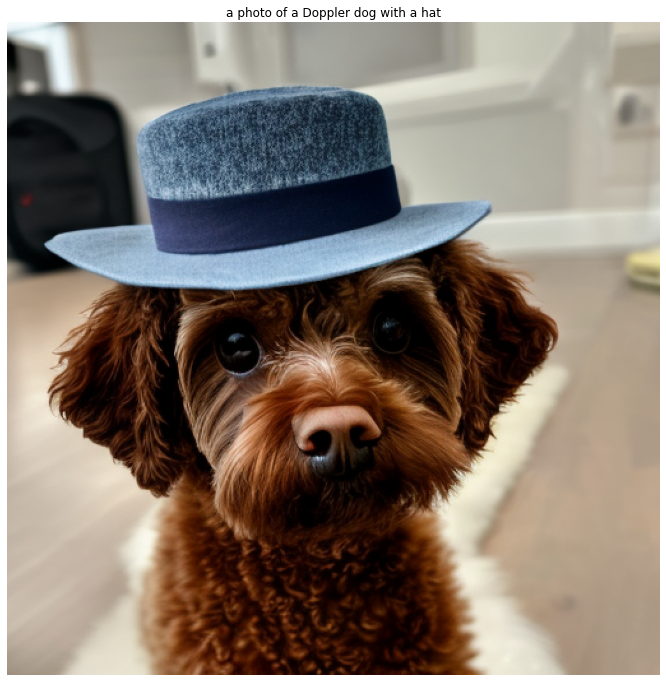

In [33]:
text = "a photo of a Doppler dog with a hat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

[2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters)에 언급된 모든 파라미터는 finetuned 모델에서도 지원됩니다. 또한, `accept`를 변경하여 [2.5. Compressed Image Output](#2.5.-Compressed-Image-Output)에서 압축 이미지 출력으로 받을 수도 있습니다.

---
다음으로 fine-tuned 모델에 해당하는 endpoint를 삭제합니다.

---

In [34]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-05-29-04-21-26-310
INFO:sagemaker:Deleting endpoint configuration with name: jumpstart-example-FT-model-txt2img-stab-2023-05-29-04-21-26-310
INFO:sagemaker:Deleting endpoint with name: jumpstart-example-FT-model-txt2img-stab-2023-05-29-04-21-26-310


## 3. Conclusion
---

인상적인 이미지를 만드는 것은 예술부터 NFTs에 이르기까지 다양한 산업에서 활용될 수 있지만, 오늘 우리는 AI가 개인화할 수 있기를 기대합니다. JumpStart는 사전 학습된 모델에 fine-tuning 기능을 제공하므로 최소 5개의 학습 이미지만으로 모델을 자신의 use case에 맞게 조정할 수 있습니다. 이는 아트, 로고, 커스텀 디자인, NFT 등을 만들 때 유용하며, 반려동물의 custom AI 이미지나 자신의 아바타를 생성하는 것과 같은 재미있는 작업을 할 때도 유용합니다. 이 실습에서는 이미지 생성 모델에 stable diffusion 텍스트를 fine-tune 하는 방법을 배웠습니다. Stable Diffusion 미세 조정에 대한 자세한 내용은 블로그 [Fine-tune text-to-image Stable Diffusion models with Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/)를 참조하세요.